# <b>AGN Percentages<b>
The ultimate goal of this notebook is to find what percentages of our AGN candidates have matches with known AGN in various other catalogues.

---

## Set-Up

For passwords and database access, and other necessary pacakges.

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import shapely.wkt as wkt
from shapely.geometry import Point

The `db.autocommit = True` statement makes the computer nicer about SQL syntax errors

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True

cursor = db.cursor(cursor_factory = psycopg2.extras.DictCursor)

DB User:  decat_ro
DB Password:  ········


As Rob has said, things in the database are tagged with versions.
Everything that's in the database should be tagged with the "latest" tag (for now).
Eventually we'll probably want to use "default".

In [3]:
tag = "latest"
db.rollback()
q = ("SELECT id,tag FROM versiontags WHERE tag=%(tag)s")
cursor.execute(q, {"tag": tag})
row = cursor.fetchone()
tagid = row['id']

## Retrive the RA and Dec of a bunch of objects in COSMOS and ELAIS

Recall that "objects" are detections in a difference image.
These objects are used to define the field boundaries.
A real/bogus score > 0.6 is required, and association with one of the 4 semesters of the DDF program.

Note that the `LIMIT 10000000` ended up being unnecessary, as <500000 objects are returned as of Dec 2022.

First for COSMOS.

In [4]:
%%time
query_cosmos = ("SELECT od.ra, od.dec "
                "FROM objectdatas AS od "
                "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
                "INNER JOIN objects AS o ON od.object_id=o.id "
                "INNER JOIN images AS i ON o.image_id=i.id "
                "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
                "INNER JOIN exposures AS e ON i.exposure_id=e.id "
                "WHERE od.ra > 147.0 AND od.ra < 154.0 AND od.dec > 0 "  # isolating COSMOS field
                "AND rbs.rb > 0.6 "
                "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
                "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
                "LIMIT 10000000")

cursor.execute(query_cosmos, {'tagid': tagid})
radecquery_cosmos = np.array(cursor.fetchall()).T
radecquery_cosmos = np.unique(radecquery_cosmos.T, axis=0).T

CPU times: user 2.51 s, sys: 227 ms, total: 2.74 s
Wall time: 7.07 s


Now for ELAIS.

In [5]:
%%time
query_elais = ("SELECT od.ra, od.dec "
               "FROM objectdatas AS od "
               "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
               "INNER JOIN objects AS o ON od.object_id=o.id "
               "INNER JOIN images AS i ON o.image_id=i.id "
               "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
               "INNER JOIN exposures AS e ON i.exposure_id=e.id "
               "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "  # isolating ELAIS field
               "AND rbs.rb > 0.6 " 
               "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
               "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
               "LIMIT 10000000")

cursor.execute(query_elais, {'tagid': tagid})
radecquery_elais = np.array(cursor.fetchall()).T
radecquery_elais = np.unique(radecquery_elais.T, axis=0).T

CPU times: user 526 ms, sys: 30 ms, total: 556 ms
Wall time: 3.21 s


Print the number of objects retrieved for COSMOS and ELAIS.

In [7]:
print(len(radecquery_cosmos[0,:]), len(radecquery_elais[0,:]))

310331 90703


## Make simple polygons enclosing our fields

"Simple" means short enough that its vertices fit in an ADQL query.

First, create polygon objects using all of the points as vertices, for COSMOS and ELAIS.

In [8]:
polystr_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_cosmos.T,2)]).replace("'","")
pol_cosmos = wkt.loads("POLYGON (({}))".format(polystr_cosmos[1:-1]+', '+polystr_cosmos[1:12]))

In [9]:
pol_cosmos

In [10]:
polystr_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(radecquery_elais.T,2)]).replace("'","")
pol_elais = wkt.loads("POLYGON (({}))".format(polystr_elais[1:-1]+', '+polystr_elais[1:12]))

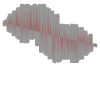

In [11]:
pol_elais

Simplify the polygons to the simplest convex shape that encloses all data.

Then plot COSMOS/ELAIS data (blue), and the simplest convex polygons enclosing all points for each field (orange lines).

In [12]:
polconvhull_cosmos = pol_cosmos.convex_hull
polconvhull_elais = pol_elais.convex_hull
convhullarr_cosmos = polconvhull_cosmos.exterior.coords.xy
convhullarr_elais = polconvhull_elais.exterior.coords.xy

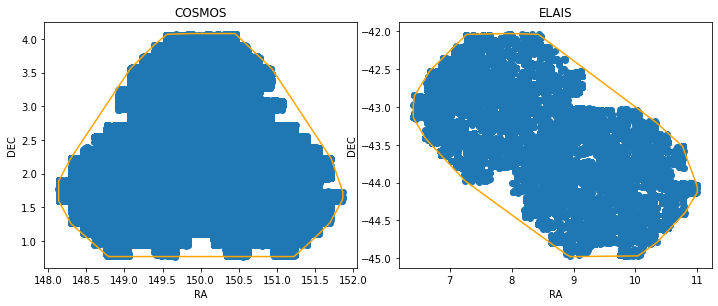

In [13]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].plot(convhullarr_cosmos[0],convhullarr_cosmos[1],color='orange') 

ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].plot(convhullarr_elais[0],convhullarr_elais[1],color='orange');

## Retrive lists of known AGN in our fields from SIMBAD

SIMBAD: http://simbad.u-strasbg.fr/simbad/sim-tap

Saved the results as {field}\_result.txt in this directory.

### All sub-catalogs

The `AGN..` means all subtypes of AGN (QSOs, seyferts, etc.).

In [24]:
print("""
SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1
GROUP BY main_id, otype_txt, ra, dec""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.73, 149.39, 3.91, 149.56, 4.07, 149.89, 4.08, 150.44, 4.08, 150.46, 4.07, 150.93, 3.56, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.69, 1.27, 151.55, 1.11, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY main_id, otype_txt, ra, dec


In [26]:
print("""
SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', {})) = 1 
GROUP BY main_id, otype_txt, ra, dec""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct main_id, ra, dec, otype_txt 
FROM basic 
WHERE otype = 'AGN..' 
AND CONTAINS(POINT('ICRS', ra, dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.68, -42.52, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1 
GROUP BY main_id, otype_txt, ra, dec


### COSMOS field, ESIS catalog AGN

In [17]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ESIS%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ESIS%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.73, 149.39, 3.91, 149.56, 4.07, 149.89, 4.08, 150.44, 4.08, 150.46, 4.07, 150.93, 3.56, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.69, 1.27, 151.55, 1.11, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### COSMOS field, COSMOS2015 catalog AGN

In [19]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'COSMOS2015%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_cosmos).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'COSMOS2015%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 148.8, 0.77, 148.78, 0.78, 148.45, 1.11, 148.3, 1.26, 148.14, 1.6, 148.14, 1.89, 148.3, 2.23, 149.08, 3.56, 149.23, 3.73, 149.39, 3.91, 149.56, 4.07, 149.89, 4.08, 150.44, 4.08, 150.46, 4.07, 150.93, 3.56, 151.71, 2.22, 151.86, 1.73, 151.86, 1.63, 151.85, 1.6, 151.69, 1.27, 151.55, 1.11, 151.39, 0.94, 151.22, 0.77, 148.8, 0.77)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### ELAIS field, ACS-GC catalog AGN

In [21]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ACS-GC%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'ACS-GC%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.68, -42.52, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### ELAIS field, SWIRE catalog AGN

In [22]:
print("""
SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'SWIRE%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', {})) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec
""".format(str(list(np.array(convhullarr_elais).T.flatten()))[1:-1]))


SELECT distinct IDENT.id, basic.ra, basic.dec, basic.otype_txt
FROM basic
JOIN IDENT on IDENT.oidref=basic.oid
WHERE basic.otype = 'AGN..'
AND IDENT.id like 'SWIRE%'
AND CONTAINS(POINT('ICRS', basic.ra, basic.dec), POLYGON('ICRS', 8.95, -44.98, 8.88, -44.95, 7.25, -43.98, 6.86, -43.64, 6.6, -43.41, 6.41, -43.14, 6.41, -42.98, 6.43, -42.85, 6.68, -42.52, 7.26, -42.05, 7.28, -42.04, 7.94, -42.03, 7.97, -42.03, 8.43, -42.04, 10.31, -43.19, 10.34, -43.21, 10.76, -43.52, 10.99, -44.03, 11.0, -44.07, 11.0, -44.13, 10.8, -44.4, 10.35, -44.79, 10.06, -44.96, 10.04, -44.97, 8.95, -44.98)) = 1
GROUP BY IDENT.id, basic.otype_txt, basic.ra, basic.dec



### Read in the query results

Define ID, RA, Dec, and type of AGN, as numpy arrays, in each catalog.

In [28]:
fnm = 'COSMOS_result.txt'
cosmos_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos_coords = np.array([cosmos_ra, cosmos_dec]).T

fnm = 'COSMOS2015_result.txt'
cosmos15_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos15_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos15_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos15_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
cosmos15_coords = np.array([cosmos15_ra, cosmos15_dec]).T

fnm = 'ACS-GC_result.txt'
acs_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
acs_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
acs_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
acs_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
acs_coords = np.array([acs_ra, acs_dec]).T

fnm = 'ELAIS_result.txt'
elais_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
elais_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
elais_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
elais_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
elais_coords = np.array([elais_ra, elais_dec]).T

fnm = 'ESIS_result.txt'
esis_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
esis_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
esis_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
esis_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
esis_coords = np.array([esis_ra, esis_dec]).T

fnm = 'SWIRE_result.txt'
swire_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
swire_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
swire_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
swire_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
swire_coords = np.array([swire_ra, swire_dec]).T

Example of the coords array:

In [29]:
esis_coords[:5]

array([[  8.45583333, -43.38527778],
       [  8.35625   , -43.36916667],
       [  8.47333333, -43.35777778],
       [  8.29208333, -43.35138889],
       [  8.46208333, -43.35222222]])

Example lengths of arrays:

In [43]:
print('COSMOS, all:      ', len(cosmos_id))
print('COSMOS, COSMOS15: ', len(cosmos15_id))
print('COSMOS, ACS-GC:   ', len(acs_id))
print(' ')
print('ELIAS, all:   ', len(elais_id))
print('ELIAS, ESIS:  ', len(esis_id))
print('ELIAS, SWIRE: ', len(swire_id))

COSMOS, all:       47081
COSMOS, COSMOS15:  3505
COSMOS, ACS-GC:    2675
 
ELIAS, all:    1485
ELIAS, ESIS:   346
ELIAS, SWIRE:  209


## Draw a tighter polygon around our fields

Create a stricter boundary by making a grid and labelling each rectangle as 'containing data' or not.

If the data are not condensed like this, making the polygon gets computationally prohibitive.

The `prec=0.05` sets the polygon parameter (grid spacing).

In [30]:
prec=0.05

Plot the COSMOS and ELAIS objects in blue, and the grid that will be used to make the polygons in black.

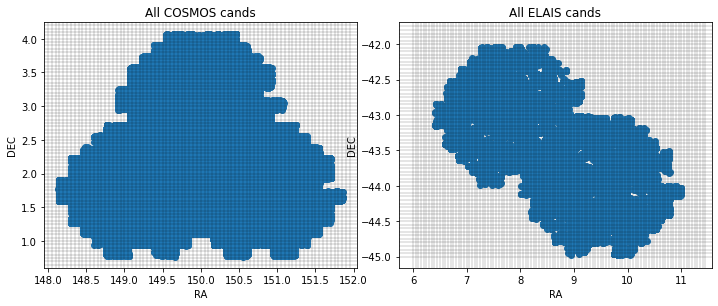

In [31]:
fig, ax = plt.subplots(1, 2) 
fig.set_size_inches(10, 4)  
fig.tight_layout()

ax[0].set_title("All COSMOS cands")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ys_cosmos = np.arange(0.65, 4.25, prec)
xs_cosmos = np.arange(148, 152, prec)
xys_cosmos = np.meshgrid(xs_cosmos, ys_cosmos)

ax[1].set_title("All ELAIS cands")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ys_elais = np.arange(-45.0, -41.7, prec)
xs_elais = np.arange(6, 11.5, prec)
xys_elais = np.meshgrid(xs_elais, ys_elais)

for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

### Identify grid boxes populated by objects

For the COSMOS and the ELAIS fields.

Use `goodxs_cosmos = xs_cosmos[goodidx_cosmos[0]] + prec/2` to get the center coordinate within the grid box.

In [32]:
good_cosmos = []
for i in range(len(xs_cosmos)):
    for j in range(len(ys_cosmos)):
        data = radecquery_cosmos[0][np.where((radecquery_cosmos[0]<xs_cosmos[i]+prec) \
                                             & (radecquery_cosmos[0]>xs_cosmos[i]) \
                                             & (radecquery_cosmos[1]<ys_cosmos[j]+prec) \
                                             & (radecquery_cosmos[1]>ys_cosmos[j]))[0]]
        if len(data) > 0:
            good_cosmos.append([i,j])
goodidx_cosmos = np.array(good_cosmos).transpose()
goodxs_cosmos = xs_cosmos[goodidx_cosmos[0]] + prec/2
goodys_cosmos = ys_cosmos[goodidx_cosmos[1]] + prec/2
goods_cosmos = np.array([goodxs_cosmos,goodys_cosmos])

good_elais = []
for i in range(len(xs_elais)):
    for j in range(len(ys_elais)):
        data = radecquery_elais[0][np.where((radecquery_elais[0]<xs_elais[i]+prec) \
                                            & (radecquery_elais[0]>xs_elais[i]) \
                                            & (radecquery_elais[1]<ys_elais[j]+prec) \
                                            & (radecquery_elais[1]>ys_elais[j]))[0]]
        if len(data) > 0:
            good_elais.append([i,j])
goodidx_elais = np.array(good_elais).transpose()
goodxs_elais = xs_elais[goodidx_elais[0]] + prec/2
goodys_elais = ys_elais[goodidx_elais[1]] + prec/2
goods_elais = np.array([goodxs_elais,goodys_elais])

Show the grid boxes populated by objects as orange.

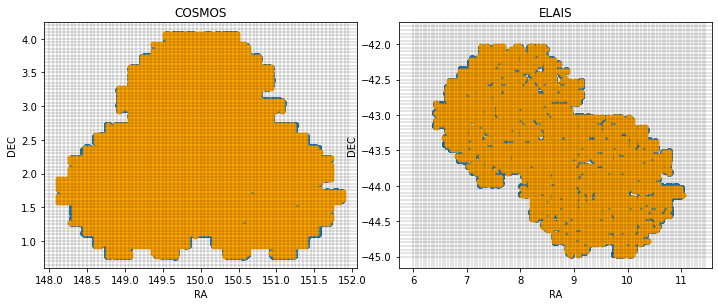

In [33]:
fig, ax = plt.subplots(1,2) 
fig.set_size_inches(10,4)  
fig.tight_layout()

ax[0].set_title("COSMOS")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
ax[0].scatter(*radecquery_cosmos)
ax[0].scatter(*goods_cosmos,lw=0.05, color='orange')

for i in ys_cosmos:
    ax[0].axhline(i, color='black',lw=0.2)
for i in xs_cosmos:
    ax[0].axvline(i, color='black',lw=0.2)
    
ax[1].set_title("ELAIS")
ax[1].set_xlabel('RA')
ax[1].set_ylabel('DEC')
ax[1].scatter(*radecquery_elais)
ax[1].scatter(*goods_elais,lw=0.05, color='orange')

for i in ys_elais:
    ax[1].axhline(i, color='black',lw=0.2)
for i in xs_elais:
    ax[1].axvline(i, color='black',lw=0.2)

### Create the new bounding polygons.

In [34]:
pol2str_cosmos = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_cosmos.T,2)]).replace("'","")
pol2_cosmos = wkt.loads("POLYGON (({}))".format(pol2str_cosmos[1:-1]+', '+pol2str_cosmos[1:12])) # COSMOS

pol2str_elais = str([str(i[0])+" "+str(i[1]) for i in np.round(goods_elais.T,2)]).replace("'","")
pol2_elais = wkt.loads("POLYGON (({}))".format(pol2str_elais[1:-1]+', '+pol2str_elais[1:12])) # ELAIS

pol3_cosmos = pol2_cosmos.buffer(prec)
pol3_elais = pol2_elais.buffer(prec)
pol3arr_cosmos = pol3_cosmos.exterior.coords.xy
pol3arr_elais = pol3_elais.exterior.coords.xy

## Identify known AGN within/outside our bounding polygons

In [37]:
%%time
cosmos_msk = []
for coord in cosmos_coords:
    pt = Point(coord[0],coord[1])
    cosmos_msk.append(pt.within(pol3_cosmos))
cosmos_coords1 = cosmos_coords[cosmos_msk]
cosmos_id1 = cosmos_id[cosmos_msk]
cosmos_type1 = cosmos_type[cosmos_msk]

cosmos15_msk = []
for coord in cosmos15_coords:
    pt = Point(coord[0],coord[1])
    cosmos15_msk.append(pt.within(pol3_cosmos))
cosmos15_coords1 = cosmos15_coords[cosmos15_msk]
cosmos15_id1 = cosmos15_id[cosmos15_msk]
cosmos15_type1 = cosmos15_type[cosmos15_msk]

acs_msk = []
for coord in acs_coords:
    pt = Point(coord[0],coord[1])
    acs_msk.append(pt.within(pol3_cosmos))
acs_coords1 = acs_coords[acs_msk]
acs_id1 = acs_id[acs_msk]
acs_type1 = acs_type[acs_msk]

CPU times: user 10.4 s, sys: 6.18 ms, total: 10.5 s
Wall time: 10.5 s


In [38]:
%%time
elais_msk = []
for coord in elais_coords:
    pt = Point(coord[0],coord[1])
    elais_msk.append(pt.within(pol3_elais))
elais_coords1 = elais_coords[elais_msk]
elais_id1 = elais_id[elais_msk]
elais_type1 = elais_type[elais_msk]

esis_msk = []
for coord in esis_coords:
    pt = Point(coord[0],coord[1])
    esis_msk.append(pt.within(pol3_elais))
esis_coords1 = esis_coords[esis_msk]
esis_id1 = esis_id[esis_msk]
esis_type1 = esis_type[esis_msk]

swire_msk = []
for coord in swire_coords:
    pt = Point(coord[0],coord[1])
    swire_msk.append(pt.within(pol3_elais))
swire_coords1 = swire_coords[swire_msk]
swire_id1 = swire_id[swire_msk]
swire_type1 = swire_type[swire_msk]

CPU times: user 533 ms, sys: 0 ns, total: 533 ms
Wall time: 531 ms


For example, print the number from each catalog that are within the boundaries.

In [45]:
print('COSMOS, all:      ', len(cosmos_id), len(cosmos_id1))
print('COSMOS, COSMOS15: ', len(cosmos15_id), len(cosmos15_id1))
print('COSMOS, ACS-GC:   ', len(acs_id), len(acs_id1))
print(' ')
print('ELIAS, all:   ', len(elais_id), len(elais_id1))
print('ELIAS, ESIS:  ', len(esis_id), len(esis_id1))
print('ELIAS, SWIRE: ', len(swire_id), len(swire_id1))

COSMOS, all:       47081 46893
COSMOS, COSMOS15:  3505 3505
COSMOS, ACS-GC:    2675 2675
 
ELIAS, all:    1485 1450
ELIAS, ESIS:   346 346
ELIAS, SWIRE:  209 206


### Visualize the known AGN within and outside the boundaries

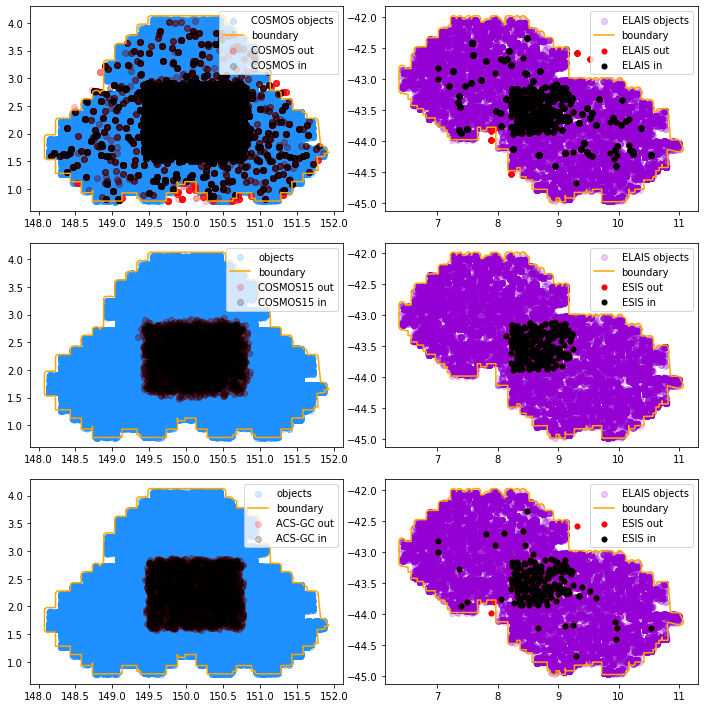

In [53]:
fig, ax = plt.subplots(3, 2) 
fig.set_size_inches(10, 10)  
fig.tight_layout()

ax[0,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='COSMOS objects')
ax[0,0].plot(*pol3arr_cosmos, color='orange', label='boundary')
ax[0,0].scatter(*cosmos_coords.T, color='red', alpha=0.2, label="COSMOS out")
ax[0,0].scatter(*cosmos_coords1.T, color='black', alpha=0.2, label="COSMOS in")
ax[0,0].legend(loc='upper right')

ax[1,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='objects')
ax[1,0].plot(*pol3arr_cosmos, color='orange',label='boundary')
ax[1,0].scatter(*cosmos15_coords.T, color='red', alpha=0.2, label="COSMOS15 out")
ax[1,0].scatter(*cosmos15_coords1.T, color='black', alpha=0.2, label="COSMOS15 in")
ax[1,0].legend(loc='upper right')

ax[2,0].scatter(*radecquery_cosmos, color='dodgerblue', alpha=0.2, label='objects')
ax[2,0].plot(*pol3arr_cosmos, color='orange',label='boundary')
ax[2,0].scatter(*acs_coords.T, color='red',alpha=0.2, label='ACS-GC out')
ax[2,0].scatter(*acs_coords1.T, color='black', alpha=0.2, label='ACS-GC in')
ax[2,0].legend(loc='upper right')

ax[0,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[0,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[0,1].scatter(*elais_coords.T, color='red', lw=0.1, label='ELAIS out')
ax[0,1].scatter(*elais_coords1.T, color='black', lw=0.1, label='ELAIS in')
ax[0,1].legend(loc='upper right')

ax[1,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[1,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[1,1].scatter(*esis_coords.T, color='red', lw=0.1, label='ESIS out')
ax[1,1].scatter(*esis_coords1.T, color='black', lw=0.1, label='ESIS in')
ax[1,1].legend(loc='upper right')

ax[2,1].scatter(*radecquery_elais, color='darkviolet', alpha=0.2, label='ELAIS objects')
ax[2,1].plot(*pol3arr_elais, color='orange', label='boundary')
ax[2,1].scatter(*swire_coords.T, color='red', lw=0.1, label='ESIS out')
ax[2,1].scatter(*swire_coords1.T, color='black', lw=0.1, label='ESIS in')
ax[2,1].legend(loc='upper right');

## Match to the 2021 sample of "probably-real" candidates

Read in the 'probably-real' candidates that were identified for the paper.

In [54]:
filename = '../extragalactic_fields/candidate_nightly_epochs_files/candidate_lightcurve_parameters.dat'
realcandsarr = np.genfromtxt(filename, dtype=str)
realcands = np.unique(realcandsarr.T[1])

Retrieve the coordinates for these candidates. Convert to `SkyCoord` format.

In [56]:
%%time
candcoord = []
for i in realcands:
    query = ("SELECT c.ra, c.dec FROM candidates c "
             "WHERE c.id = %s "
             "LIMIT 1")
    cursor.execute(query,(i,))
    res = np.array(cursor.fetchall())[0]
    candcoord.append([i,res])
candcoord1 = np.array([[i[0], SkyCoord(i[1][0],i[1][1], unit='deg')] for i in candcoord])

CPU times: user 3.53 s, sys: 164 ms, total: 3.69 s
Wall time: 5.92 s


Also convert the coordinates of the known AGN from SIMBAD into `SkyCoord` format.

In [57]:
cosmos_coords2 = SkyCoord(cosmos_coords1, unit='deg')
cosmos15_coords2 = SkyCoord(cosmos15_coords1, unit='deg')
acs_coords2 = SkyCoord(acs_coords1, unit='deg')

elais_coords2 = SkyCoord(elais_coords1, unit='deg')
esis_coords2 = SkyCoord(esis_coords1, unit='deg')
swire_coords2 = SkyCoord(swire_coords1, unit='deg')

Match the datasets with a 2 arcsec radius.

In [58]:
%%time

cosmos_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos_coords2)
    if sep2d < 2*u.arcsec:
        cosmos_matches.append([i,coord,idx, sep2d])
cosmos_matches = np.array(cosmos_matches)

cosmos15_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(cosmos15_coords2)
    if sep2d < 2*u.arcsec:
        cosmos15_matches.append([i,coord,idx, sep2d])
cosmos15_matches = np.array(cosmos15_matches)

acs_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(acs_coords2)
    if sep2d < 2*u.arcsec:
        acs_matches.append([i,coord,idx, sep2d])
acs_matches = np.array(acs_matches)

elais_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(elais_coords2)
    if sep2d < 2*u.arcsec:
        elais_matches.append([i,coord,idx, sep2d])
elais_matches = np.array(elais_matches)

esis_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(esis_coords2)
    if sep2d < 2*u.arcsec:
        esis_matches.append([i,coord,idx, sep2d])
esis_matches = np.array(esis_matches)

swire_matches = []
for i, coord in enumerate(candcoord1.T[1]):
    idx, sep2d, dist3d = coord.match_to_catalog_sky(swire_coords2)
    if sep2d < 2*u.arcsec:
        swire_matches.append([i,coord,idx, sep2d])
swire_matches = np.array(swire_matches)

<timed exec>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<timed exec>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<timed exec>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<timed exec>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wi

CPU times: user 1min 2s, sys: 43.1 ms, total: 1min 2s
Wall time: 1min 2s


<timed exec>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Print the percentages of known agn matched to our agn candidates

In [59]:
### Display percentages matched for COSMOS
cosmos_matchmsk = cosmos_matches.T[2].astype(int)
cosmos15_matchmsk = cosmos15_matches.T[2].astype(int)
acs_matchmsk = acs_matches.T[2].astype(int)

cosmos_coordsmatched = cosmos_coords1[cosmos_matchmsk]
cosmos15_coordsmatched = cosmos15_coords1[cosmos15_matchmsk]
acs_coordsmatched = acs_coords1[acs_matchmsk]

cosmos_typesmatched = cosmos_type1[cosmos_matchmsk]
cosmos15_typesmatched = cosmos15_type1[cosmos15_matchmsk]
acs_typesmatched = acs_type1[acs_matchmsk]

cosmos_idmatched = cosmos_id1[cosmos_matchmsk]
cosmos15_idmatched = cosmos15_id1[cosmos15_matchmsk]
acs_idmatched = acs_id1[acs_matchmsk]

print("For the COSMOS field:")

print("\nUsing this file: ./COSMOS_result.txt")
for typee in np.unique(cosmos_type):
    cosmos_msk = np.where(cosmos_typesmatched==typee)[0]
    cosmos_nummatched = len(cosmos_idmatched[cosmos_msk])
    try:
        cosmos_numtot = len(cosmos_id1[cosmos_type1==typee])
        cosmos_perc = np.round(cosmos_nummatched/cosmos_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos_nummatched, cosmos_numtot,typee,cosmos_perc))
        #print(f"found {cosmos_nummatched} out of {cosmos_numtot} {typee} ({cosmos_nummatched/cosmos_numtot*100:.2f} %)")
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(cosmos_matches), len(cosmos_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(cosmos_matches)/len(cosmos_coords1)*100,2)))

print("\nUsing this file: ./COSMOS2015_result.txt")
for typee in np.unique(cosmos15_type):
    cosmos15_msk = np.where(cosmos15_typesmatched==typee)[0]
    cosmos15_nummatched = len(cosmos15_idmatched[cosmos15_msk])
    try:
        cosmos15_numtot = len(cosmos15_id1[cosmos15_type1==typee])
        cosmos15_perc = np.round(cosmos15_nummatched/cosmos15_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(cosmos15_nummatched, cosmos15_numtot,typee,cosmos15_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(cosmos15_matches), len(cosmos15_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(cosmos15_matches)/len(cosmos15_coords1)*100,2)))

print("\nUsing this file: ./ACS-GC_result.txt")
for typee in np.unique(acs_type):
    acs_msk = np.where(acs_typesmatched==typee)[0]
    acs_nummatched = len(acs_idmatched[acs_msk])
    try:
        acs_numtot = len(acs_id1[acs_type1==typee])
        acs_perc = np.round(acs_nummatched/acs_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(acs_nummatched, acs_numtot,typee,acs_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(acs_matches), len(acs_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(acs_matches)/len(acs_coords1)*100,2)))

For the COSMOS field:

Using this file: ./COSMOS_result.txt
found 99 out of 35777 "AGN"     (0.28 %)
found 0 out of 46 "BLL"     (0.0 %)
found 0 out of 346 "LIN"     (0.0 %)
found 190 out of 6505 "QSO"     (2.92 %)
found 14 out of 662 "Sy1"     (2.11 %)
found 1 out of 224 "Sy2"     (0.45 %)
found 0 out of 1 "SyG"     (0.0 %)
found 4 out of 3332 "rG"      (0.12 %)
We detected 308 known agn as 'probably-real' candidates, out of 46893 known agn
This represents 0.66 % of all the known agn in our field

Using this file: ./COSMOS2015_result.txt
found 88 out of 3006 "AGN"     (2.93 %)
found 0 out of 1 "BLL"     (0.0 %)
found 0 out of 10 "LIN"     (0.0 %)
found 84 out of 270 "QSO"     (31.11 %)
found 6 out of 22 "Sy1"     (27.27 %)
found 0 out of 4 "Sy2"     (0.0 %)
found 3 out of 192 "rG"      (1.56 %)
We detected 181 known agn as 'probably-real' candidates, out of 3505 known agn
This represents 5.16 % of all the known agn in our field

Using this file: ./ACS-GC_result.txt
found 67 out of 235

In [60]:
### Display percentages matched for ELAIS

elais_matchmsk = elais_matches.T[2].astype(int)
esis_matchmsk = esis_matches.T[2].astype(int)
swire_matchmsk = swire_matches.T[2].astype(int)

elais_coordsmatched = elais_coords1[elais_matchmsk]
esis_coordsmatched = esis_coords1[esis_matchmsk]
swire_coordsmatched = swire_coords1[swire_matchmsk]

elais_typesmatched = elais_type1[elais_matchmsk]
esis_typesmatched = esis_type1[esis_matchmsk]
swire_typesmatched = swire_type1[swire_matchmsk]

elais_idmatched = elais_id1[elais_matchmsk]
esis_idmatched = esis_id1[esis_matchmsk]
swire_idmatched = swire_id1[swire_matchmsk]

print("For the ELAIS field:")

print("\nUsing this file: ./ELAIS_result.txt")
for typee in np.unique(elais_type):
    elais_msk = np.where(elais_typesmatched==typee)[0]
    elais_nummatched = len(elais_idmatched[elais_msk])
    try:
        elais_numtot = len(elais_id1[elais_type1==typee])
        elais_perc = np.round(elais_nummatched/elais_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(elais_nummatched, elais_numtot,typee,elais_perc))
        #print(f"found {elais_nummatched} out of {elais_numtot} {typee} ({elais_perc} %)")
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(elais_matches), len(elais_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(elais_matches)/len(elais_coords1)*100,2)))

print("\nUsing this file: ./ESIS_result.txt")
for typee in np.unique(esis_type):
    esis_msk = np.where(esis_typesmatched==typee)[0]
    esis_nummatched = len(esis_idmatched[esis_msk])
    try:
        esis_numtot = len(esis_id1[esis_type1==typee])
        esis_perc = np.round(esis_nummatched/esis_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(esis_nummatched, esis_numtot,typee,esis_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(esis_matches), len(esis_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(esis_matches)/len(esis_coords1)*100,2)))

print("\nUsing this file: ./SWIRE_result.txt")
for typee in np.unique(swire_type):
    swire_msk = np.where(swire_typesmatched==typee)[0]
    swire_nummatched = len(swire_idmatched[swire_msk])
    try:
        swire_numtot = len(swire_id1[swire_type1==typee])
        swire_perc = np.round(swire_nummatched/swire_numtot*100,2)
        print("found {} out of {} {} ({} %)".format(swire_nummatched, swire_numtot,typee,swire_perc))
    except:
        pass
print("We detected {} known agn as 'probably-real' candidates, out of {} known agn".format(len(swire_matches), len(swire_coords1)))
print("This represents {} % of all the known agn in our field".format(np.round(len(swire_matches)/len(swire_coords1)*100,2)))

For the ELAIS field:

Using this file: ./ELAIS_result.txt
found 36 out of 934 "AGN"     (3.85 %)
found 0 out of 58 "LIN"     (0.0 %)
found 8 out of 259 "QSO"     (3.09 %)
found 1 out of 51 "Sy1"     (1.96 %)
found 0 out of 136 "Sy2"     (0.0 %)
found 1 out of 8 "SyG"     (12.5 %)
found 0 out of 4 "rG"      (0.0 %)
We detected 46 known agn as 'probably-real' candidates, out of 1450 known agn
This represents 3.17 % of all the known agn in our field

Using this file: ./ESIS_result.txt
found 28 out of 316 "AGN"     (8.86 %)
found 0 out of 3 "LIN"     (0.0 %)
found 3 out of 24 "QSO"     (12.5 %)
found 0 out of 2 "Sy1"     (0.0 %)
found 0 out of 1 "Sy2"     (0.0 %)
We detected 31 known agn as 'probably-real' candidates, out of 346 known agn
This represents 8.96 % of all the known agn in our field

Using this file: ./SWIRE_result.txt
found 16 out of 178 "AGN"     (8.99 %)
found 0 out of 2 "LIN"     (0.0 %)
found 2 out of 14 "QSO"     (14.29 %)
found 0 out of 3 "Sy1"     (0.0 %)
found 0 out of